In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1)

# rcParams['figure.figsize'] = 10, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
def plot_scaling_result(data, scaled_data, scaling_title, x_lim=(-5, 5)):

  scaled_df = pd.DataFrame(
      scaled_data, 
      columns=['Normal', 'Exponential', 'Uniform']
  )

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  ax1.set_xlim((-300, 300))
  ax1.set_title('No Scaling')
  sns.kdeplot(data.Normal, ax=ax1)
  sns.kdeplot(data.Exponential, ax=ax1)
  sns.kdeplot(data.Uniform, ax=ax1)

  ax2.set_xlim(x_lim)
  ax2.set_title(scaling_title)
  sns.kdeplot(scaled_df.Normal, ax=ax2)
  sns.kdeplot(scaled_df.Exponential, ax=ax2)
  sns.kdeplot(scaled_df.Uniform, ax=ax2);

In [3]:
data = pd.DataFrame(
    {
        'Normal': np.random.normal(100,50,1000),
        'Exponential': np.random.exponential(25,1000),
        'Uniform': np.random.uniform(-150,-50,1000)
    }
)

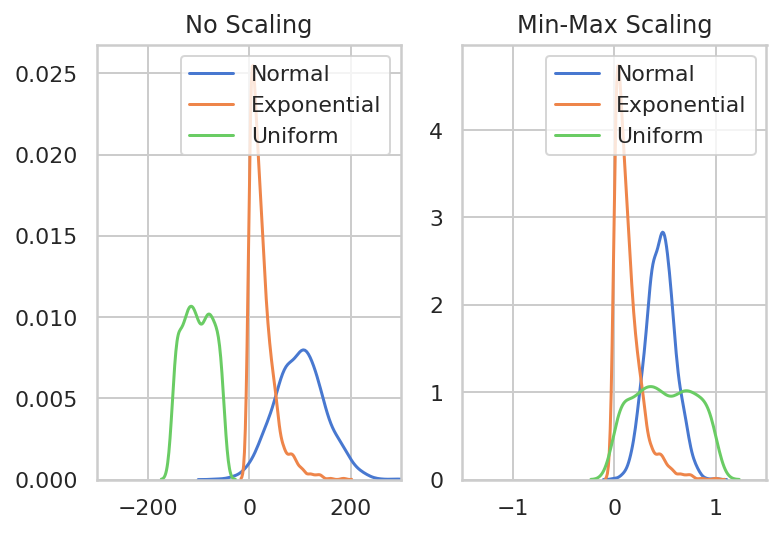

In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(data)
# plot_scaling_result(data,min_max_scaled,'Min Max Scaler')
plot_scaling_result(data, min_max_scaled, 'Min-Max Scaling', (-1.5, 1.5))


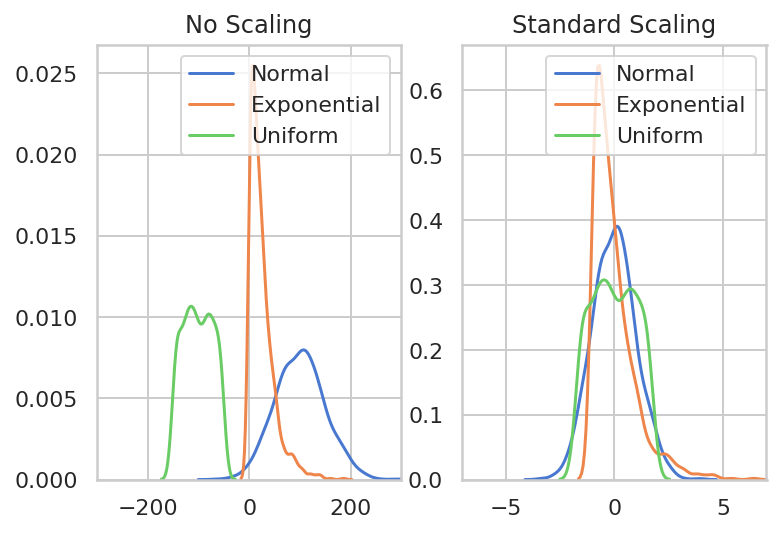

In [5]:
from sklearn.preprocessing import StandardScaler

stand_scaled = StandardScaler().fit_transform(data)
plot_scaling_result(data, stand_scaled, 'Standard Scaling', (-7, 7))

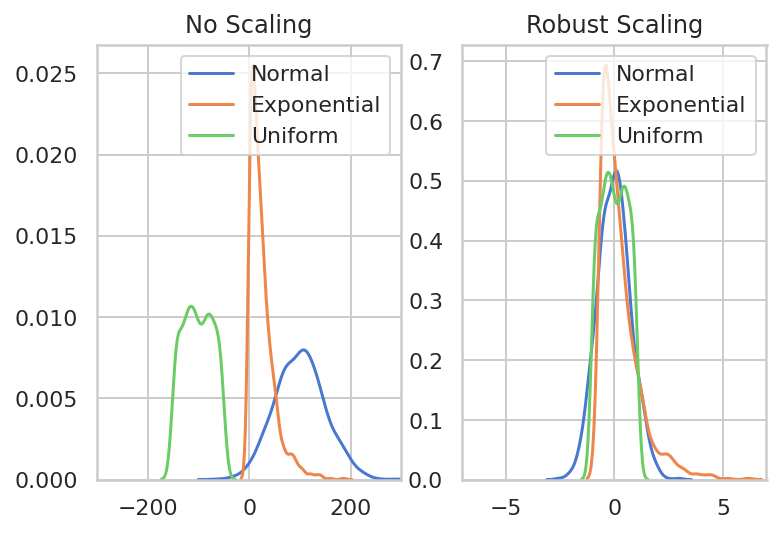

In [6]:
from sklearn.preprocessing import RobustScaler

robust_scaled = RobustScaler().fit_transform(data)
plot_scaling_result(data, robust_scaled, 'Robust Scaling', (-7, 7))


In [7]:
property_type = np.array(['House', 'Unit', 'Townhouse', 'House', 'Unit']).reshape(-1, 1)

In [8]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder().fit(property_type)
labels = enc.transform(property_type)
labels.flatten()

array([0., 2., 1., 0., 2.])

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False).fit(property_type)
one_hots = enc.transform(property_type)
one_hots

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [10]:
n_rooms = np.array([1, 2, 1, 4, 6, 7, 12, 20])
pd.cut(n_rooms, bins=[0, 3, 8, 100], labels=["small", "medium", "large"])

[small, small, small, medium, medium, medium, large, large]
Categories (3, object): [small < medium < large]

In [11]:
dates = pd.Series(["1/04/2017", "2/04/2017", "3/04/2017"])
pd_dates = pd.to_datetime(dates)
pd_dates.dt.dayofweek

0    2
1    5
2    5
dtype: int64

# Melbourne House Pricing

## Data from Kaggle: https://www.kaggle.com/anthonypino/melbourne-housing-market/

In [12]:
df = pd.read_csv('assets/MELBOURNE_HOUSE.csv')
df.shape

(63023, 13)

In [13]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Price    14590
dtype: int64

In [14]:
df = df.dropna()

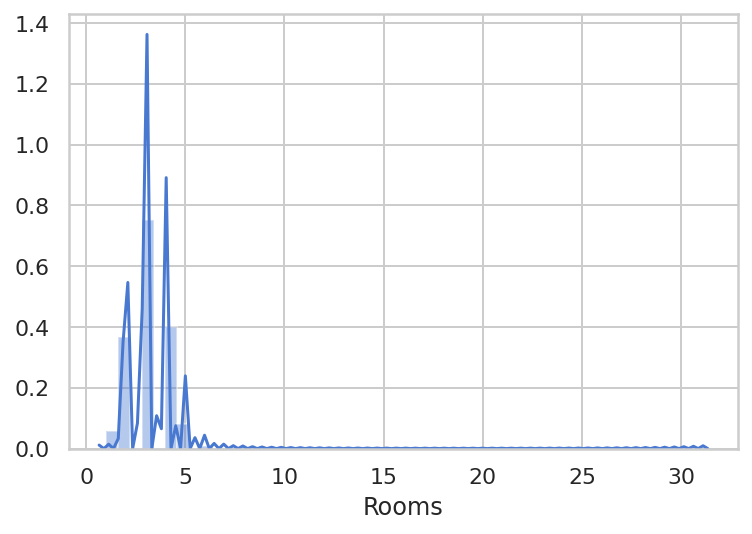

In [15]:
sns.distplot(df.Rooms.dropna());

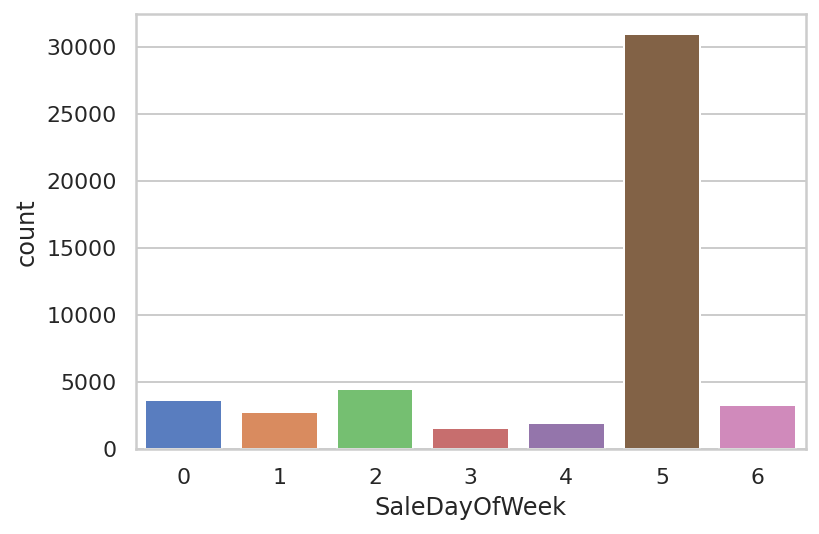

In [16]:
df['Date'] = pd.to_datetime(df.Date)
df['SaleDayOfWeek'] = df.Date.dt.dayofweek
sns.countplot(df.SaleDayOfWeek);

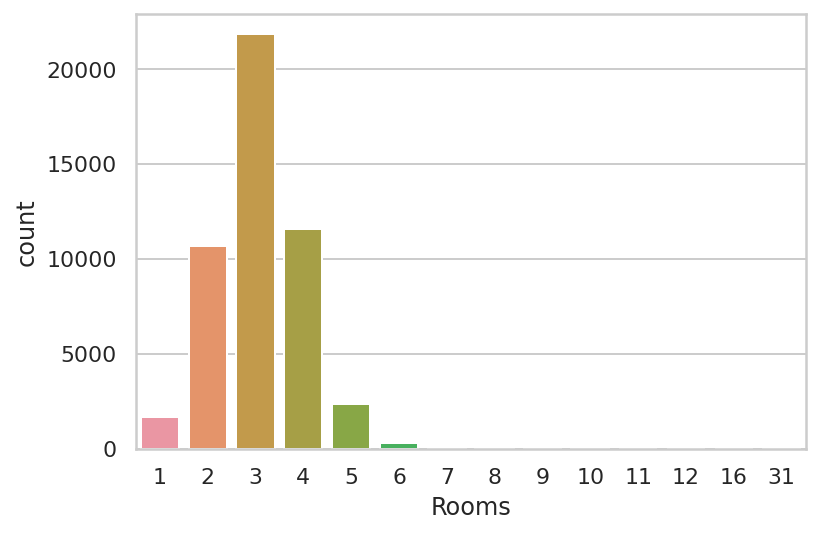

In [17]:
sns.countplot(df.Rooms);

In [18]:
X = df[['Rooms', 'Distance', 'Propertycount', 'Postcode']]
y = np.log1p(df.Price.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

from sklearn.ensemble import GradientBoostingRegressor

base_model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, random_state=RANDOM_SEED).fit(X_train, y_train)

base_model.score(X_test, y_test)

0.7133676884484994

In [19]:
y_base_pred = base_model.predict(X_test)


In [20]:
df['Size'] = pd.cut(df.Rooms, bins=[0, 2, 4, 100], labels=["Small", "Medium", "Large"])
df = df.drop(['Address', 'Date'], axis=1)

In [21]:
X = df.drop('Price', axis=1)
y = np.log1p(df.Price.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [22]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(    
    (RobustScaler(), ['Distance', 'Propertycount', 'Postcode','Rooms']),
    (OneHotEncoder(handle_unknown="ignore"), ['Size', 'SaleDayOfWeek', 'Type', 'Method', 'Regionname']),
    (OrdinalEncoder(
        categories=[X.CouncilArea.unique(), X.SellerG.unique(), X.Suburb.unique()], 
        dtype=np.int32
      ), ['CouncilArea', 'SellerG', 'Suburb']
    ),
)

In [23]:
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [24]:
X.shape


(48433, 12)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

final_model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=150, random_state=RANDOM_SEED).fit(X_train, y_train)
final_model.score(X_test, y_test)

0.7915084928841826

In [26]:
y_final_pred = final_model.predict(X_test)

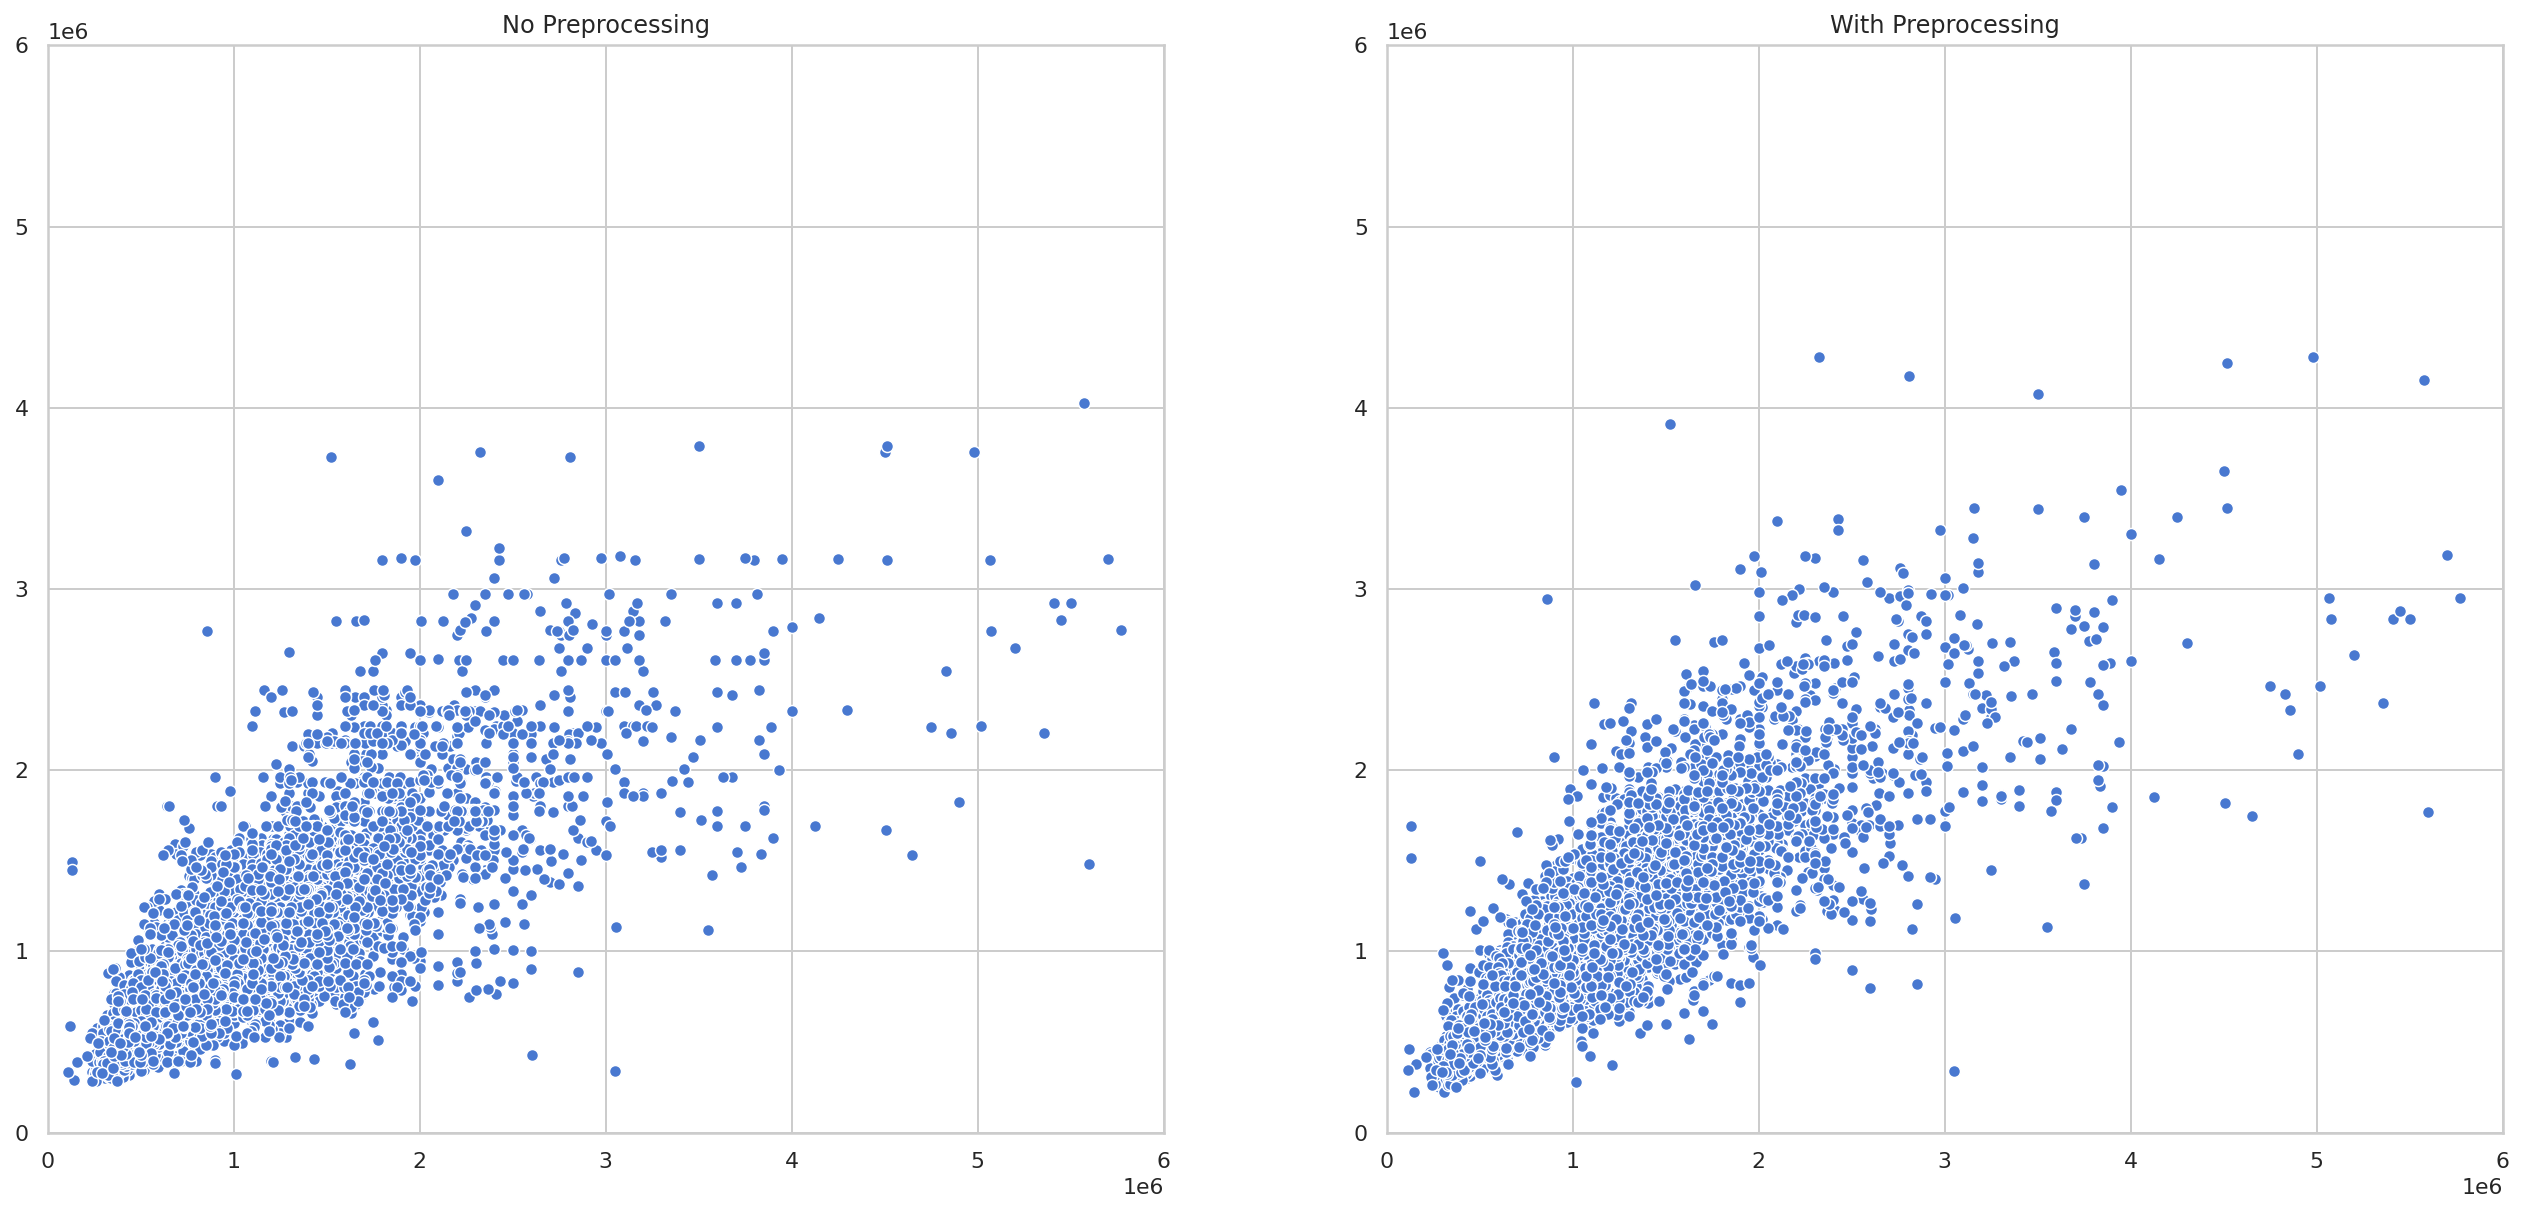

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(22, 10))

ax1.set_xlim((0, 6000000))
ax1.set_ylim((0, 6000000))
ax1.set_title('No Preprocessing')
sns.scatterplot(np.expm1(y_test), np.expm1(y_base_pred), ax=ax1)

ax2.set_xlim((0, 6000000))
ax2.set_ylim((0, 6000000))
ax2.set_title('With Preprocessing')
sns.scatterplot(np.expm1(y_test), np.expm1(y_final_pred), ax=ax2);